# Table of Content
* [Goal](#Goal)
* [Wrangle](#Wrangle)
* [Explore Data Analysis](#Explore)
  * [Overall Top 20](#Over-All-Top-20-Words)
  * [Each Langauge's Top 10 Words](#Top-10-Words-from-Javascript-and-Python)
* [Models](#Model)
* [Conclusion](#Conclusion)

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from prepare import prep_gitMDs
from wordcloud import WordCloud

print('Initalized')

Initalized


# Goal
The goal of this project is to use Natural Language Processing (NLP) to predict the primary coding language of a gitrepo using the repo's README.  

# Wrangle
We will use the modules ***[prepare.py](https://github.com/NLP-MVPs/nlp-project/blob/main/prepare.py)*** to gather the data, clean the data, and put it into a dataframe. From there we will begin to wrangle the data for exploration focusining mainly on creating word strings and additional dataframe from our data.

[Table of Content](#Table-of-Content)

In [2]:
help(prep_gitMDs)

Help on function prep_gitMDs in module prepare:

prep_gitMDs()
    Uses the helper functions contained within the prepare.py module on the gitMDs repo url list from the acquire.py module to create a unified data frame for exploration
    * Applies a basic_body_clean, tokenizizatize, removestop_words, AND lemmatizes fuctions to the readme body text
      and returns the output as df['clean'].
    * Applies the basic_code_clean, tokenizizatize, and removestop_words fuctions to the top_code 
      and returns it as df['top_code_cleaned]
    * Splits df['top_code_cleaned] into two columns df['top_code_cleaned'] and df['top_percentage_cleaned']
    * Returns the gitMDs as a data frame



In [3]:
# Use the prep_gitMDs fuction to run the acquire and prepare scripts
df = prep_gitMDs()
df

,body,top_code,clean,top_code_clean,percentage
0,\n\n\n\n\nfreeCodeCamp.org's open-source codeb...,\n\nJavaScript\n91.3%\n,freecodecamporg ' opensource codebase curricul...,javascript,91.3
1,\n\n\n\n\n\n\n\n\n\n\nSupporting Vue.js\nVue.j...,\n\nJavaScript\n97.7%\n,supporting vuejs vuejs mitlicensed open source...,javascript,97.7
2,React · \nReact is a JavaScript library for...,\n\nJavaScript\n95.0%\n,react react javascript library building user i...,javascript,95.0
3,"\n\n\n\n\nBootstrap\n\n Sleek, intuitive, and...",\n\nJavaScript\n46.7%\n,bootstrap sleek intuitive powerful frontend fr...,javascript,46.7
4,Airbnb JavaScript Style Guide() {\nA mostly re...,\n\nJavaScript\n100.0%\n,airbnb javascript style guide mostly reasonabl...,javascript,100.0
...,...,...,...,...,...
224,\n\n\n\n An Apache 2.0 NLP research library...,\n\nPython\n97.6%\n,apache 20 nlp research library built pytorch d...,python,97.6
225,\n\n\n\n\nAbout\nWifiphisher is a rogue Access...,\n\nPython\n76.3%\n,wifiphisher rogue access point framework condu...,python,76.3
226,httpbin(1): HTTP Request & Response Service\nA...,\n\nPython\n74.6%\n,httpbin1 http request response service kenneth...,python,74.6
227,"一些非常有趣的python爬虫例子,对新手比较友好\n\n\n\n\n\n\n\n\n\n\...",\n\nPython\n88.1%\n,python python gitee 1 chrome chromechromedrive...,python,88.1


In [4]:
# create series objects for each top_code_clean that is a string of words joined on spaces to make it 1 continious string  
# for python
python_words = ' '.join(df[df.top_code_clean=='python'].clean)
# for javascript
javascript_words = ' '.join(df[df.top_code_clean=='javascript'].clean)
# both python and java script
all_words = ' '.join(df.clean)

In [5]:
# Then for each series remove any by itself characters to reduce noise
python_words = re.sub(r'\s.\s', '', python_words)
javascript_words = re.sub(r'\s.\s', '', javascript_words)
all_words = re.sub(r'\s.\s', '', all_words)

In [6]:
# For each top_code_clean find out how many times each word happens and put that into a topic_freq obj.
all_freq = pd.Series(all_words.split()).value_counts()
python_freq = pd.Series(python_words.split()).value_counts()
javascript_freq = pd.Series(javascript_words.split()).value_counts()


python_freq.head()

python      843
learning    696
yes         692
data        679
use         580
dtype: int64

In [7]:
# Combine all the series together into a single data frame to see the word count across all topics
word_counts = (pd.concat([all_freq, python_freq, javascript_freq], axis=1, sort=True)
               .set_axis(['all', 'python', 'javascript', ], axis=1, inplace=False)
               .fillna(0)
               .apply(lambda s: s.astype(int))
              )

word_counts.head()

,all,python,javascript
&#9;,757,144,613
&#9;&#9;p,1,1,0
&#9;110,1,0,1
&#9;111,1,0,1
&#9;112,1,0,1


Create a list of words that combines the top 10 words used by javascript and python into a single list, and then create a top10 dataframe that only looks at those words.

In [8]:
# Top 10 words used by javascript
top_10_js_words = word_counts['javascript'].sort_values(ascending=False).head(10)
# top 10 words by python
top_10_py_words = word_counts['python'].sort_values(ascending=False).head(10)
# combines the lists together
top_10_each = (list(top_10_py_words.index) + list(top_10_js_words.index))

# Create the new data frame where the index values match the top_10_each value
top10 = word_counts[word_counts.index.isin(top_10_each)]
# Print the data frame
top10

,all,python,javascript
&#9;,757,144,613
code,1752,393,1359
data,983,679,304
file,1127,452,675
function,856,119,737
javascript,771,45,726
learning,745,696,49
library,808,567,241
native,950,23,927
network,616,560,56


# Explore

Now that the data has been processed into more usable forms we can begin to explore the data for features we can use in building our models. We will create a wordcloud and frequency chat from the top 20 words used across both programing lanauges, and then we will create a frequency chart and word cloud charts from our top10 words data frame.

[Table of Content](#Table-of-Content)

## Over All Top 20 Words

[Table of Content](#Table-of-Content)

In [9]:
# Create a top 20 all_words df
top_20_all_words = word_counts['all'].sort_values(ascending=False).head(20)
top_20_all_words

code          1752
use           1345
source        1320
file          1127
using         1067
python        1006
data           983
react          969
native         950
project        894
not            861
function       856
library        808
javascript     771
&#9;           757
learning       745
example        734
install        730
new            721
yes            701
Name: all, dtype: int32

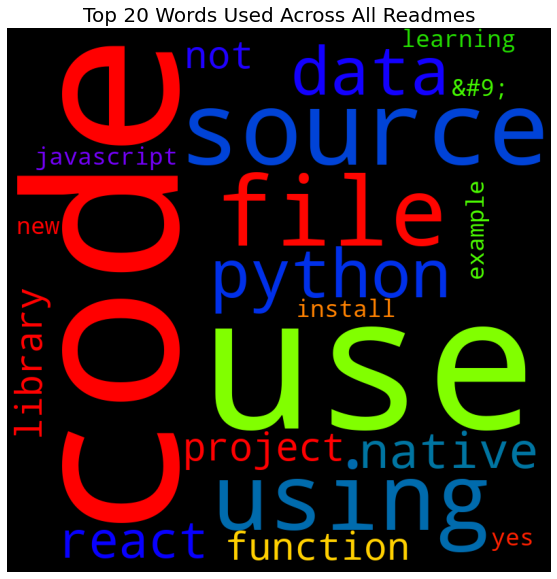

In [10]:
# Turn the dataframes into dictionaries
allz = {k: v for k, v in top_20_all_words.to_dict().items()}

# Use the dictionary objects and .generate_from_frequencies method of WordCloud to generate a wordcloud map for each language
all_top_20_cloud = WordCloud(background_color='black', 
                      height=800, width=800, colormap='prism').generate_from_frequencies(allz)

plt.figure(figsize=(10,10))
plt.title("Top 20 Words Used Across All Readmes", fontsize=20)
plt.imshow(all_top_20_cloud)
plt.axis('off')
plt.show()

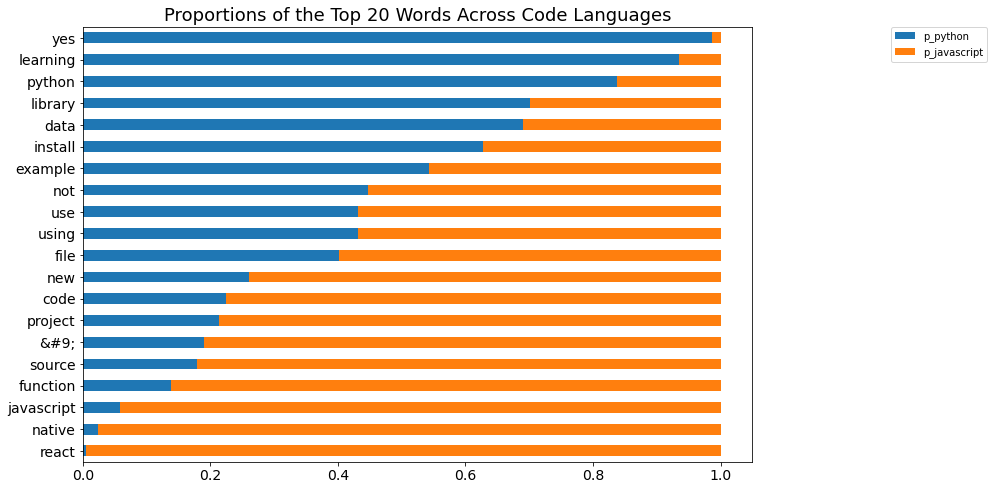

In [11]:
# visualize the percentage each coding language makes up for the top 20 words
(word_counts.assign(p_python = word_counts.python/word_counts['all'], 
                   p_javascript = word_counts.javascript/word_counts['all'])
 .sort_values(by='all')[['p_python', 'p_javascript']]
 .tail(20)
 .sort_values(by='p_python')
 .plot.barh(stacked=True, figsize=(12,8))
)
plt.title("Proportions of the Top 20 Words Across Code Languages", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.35, 1),borderaxespad=0)
plt.show()

## Top 10 Words from Javascript and Python

[Table of Content](#Table-of-Content)

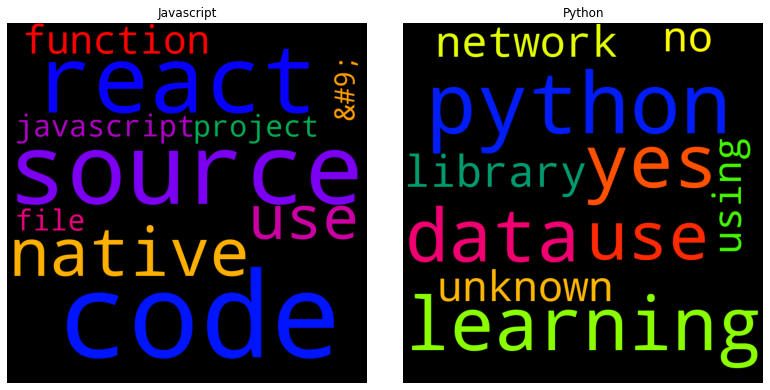

In [12]:
# Createa a top 10 words for each javascript and python
top_10_js_words = word_counts['javascript'].sort_values(ascending=False).head(10)
top_10_py_words = word_counts['python'].sort_values(ascending=False).head(10)

# Turn the dataframes into dictionaries
js = {k: v for k, v in top_10_js_words.to_dict().items()}
py = {k: v for k, v in top_10_py_words.to_dict().items()}


# Use the dictionary objects and .generate_from_frequencies method of WordCloud to generate a wordcloud map for each language
js10_cloud = WordCloud(background_color='black', 
                      height=800, width=800, colormap='prism').generate_from_frequencies(js)

py10_cloud = WordCloud(background_color='black', 
                      height=800, width=800, colormap='prism').generate_from_frequencies(py)

# Change the figure size
plt.figure(figsize=(10,10))
axs = [plt.axes([.25, 1, .5, .5]), plt.axes([.8, 1, .5, .5])]

# imshow => display data as an image
axs[0].imshow(js10_cloud)
axs[1].imshow(py10_cloud)

axs[0].set_title('Javascript')
axs[1].set_title('Python')

# Turn off the axis
for ax in axs: ax.axis('off')

<Figure size 1440x1008 with 0 Axes>

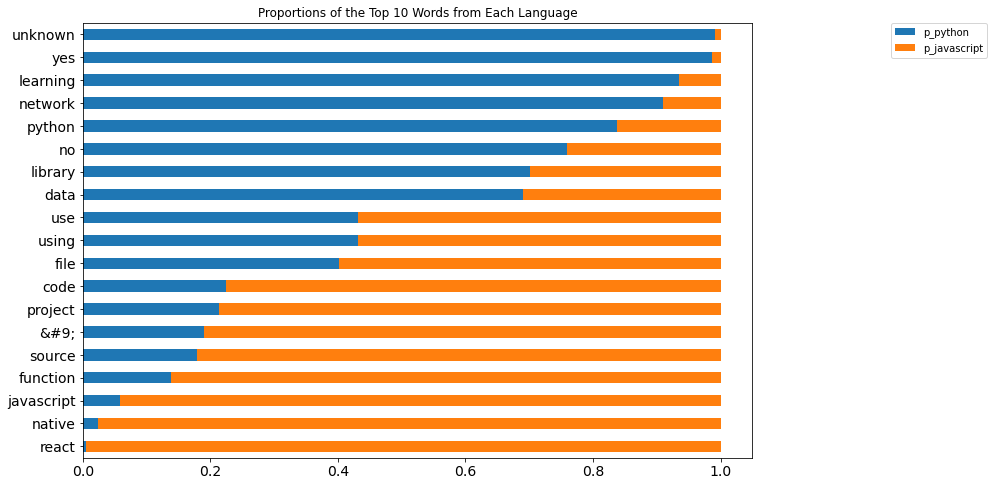

In [13]:
# visualize the percentage each coding language makes up for the top 10words of each programing language
plt.figure(figsize=(20,14))
(top10.assign(p_python = top10.python/top10['all'], 
                   p_javascript = top10.javascript/top10['all'])
 .sort_values(by='all')[['p_python', 'p_javascript']]
 .tail(20)
 .sort_values(by='p_python')
 .plot.barh(stacked=True, figsize=(12,8))
)

plt.title("Proportions of the Top 10 Words from Each Language")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(bbox_to_anchor=(1.35, 1),borderaxespad=0)
plt.show()

# Model
[Table of Content](#Table-of-Content)

# Conclusion

[Table of Content](#Table-of-Content)